# 视频物体分割
本案例分为以下几个章节：
1. 视频物体分割简介
2. OSVOS算法训练和预测
3. 视频物体分割的应用

下面我们开始本案例的学习，由于本案例的代码是在华为云ModelArts Notebook上运行，所以需要先按照如下步骤来进行Notebook环境的准备。

### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts Notebook

下面，我们在ModelArts中创建一个Notebook开发环境，ModelArts Notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./imgs/create_nb_create_button.png)

第二步：填写notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费  |
| 名称 | 自定义名称 |
| 工作环境 | Python3 |
| 资源池 | 公共资源池 |
| 类型 | GPU |
| 规格 | [限时免费]体验规格GPU版 |
| 存储配置 | EVS |
| 磁盘规格 | 5GB |

第三步：配置好Notebook参数后，点击下一步，进入Notebook信息预览。确认无误后，点击“立即创建”

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./imgs/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![enter_dev_env](imgs/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后创建Pytorch-1.0.0开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"object_segmentation"
![notebook_untitled_filename](./imgs/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./imgs/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./imgs/run_helloworld.png)



## 1. 视频物体分割简介
视频物体分割就是从视频所有图像中将感兴趣物体的区域完整地分割出来。

注意“感兴趣物体”这个词，“感兴趣物体”是指在一段视频中最容易捕获人眼注意力的一个或多个物体，比如下图中左上角子图中三个正在跳舞的人，这三个人物是“感兴趣物体”，而周围的人群不属于我们常识上的感兴趣物体，下图中的其他子图也是如此，因此视频物体分割算法一般不需要将视频图像中的所有物体都进行分割，而是只需要分割“感兴趣物体”即可。

![vos.jpg](./imgs/vos.jpg)

学术界在视频物体分割领域主要有三个研究方向：

（1）半监督视频物体分割

（2）交互式视频物体分割

（3）无监督视频物体分割

下面我们来一一讲解三个研究方向的内容。

### 1.1 半监督视频物体分割

半监督是指由用户给定感兴趣物体在视频第一帧图片上的人工标注真实分割区域，然后算法根据这一帧图片和标注进行学习，完成学习后，由算法来对后续所有帧图片进行分割区域的预测。

![semi_learning](./imgs/semi_learning.jpg)

如上图所示，第一行分别是一个视频的RGB图片，第二行是感兴趣物体区域，第一列是视频的第一帧图片和人工标注的分割区域，之后的三列分别是第20、40、60帧图片和算法预测的分割区域。

半监督视频物体分割算法还可以再分为两类：有在线学习和无在线学习。有在线学习的算法就是上面提到的根据第一帧物体的 ground-truth，利用 one-shot learning 的策略来 fine-tune 分割模型，每次对一个视频进行预测前，都要先对该视频的第一帧进行学习，fine-tune一下模型，再进行预测，代表性算法是[One-Shot Video Object Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Caelles_One-Shot_Video_Object_CVPR_2017_paper.pdf)。无在线学习的算法是指它的模型是事先训练好的，不需要针对样本进行 fine-tune，具有更好的时效性，代表性算法是[FEELVOS: Fast End-to-End Embedding Learning for Video Object Segmentation](https://arxiv.org/pdf/1902.09513)。

### 1.2 交互式视频物体分割

交互式视频物体分割是指算法在运行过程中需要人不断与其交互，然后根据人的交互信息来决定感兴趣物体并进行分割。

![interactive_learning](./imgs/interactive_learning.jpg)

如上图所示，是交互式视频物体分割算法的基本流程，第一帧根据人划的一条线或一个框来确定感兴趣物体，然后得到初始帧的物体分割结果，然后算法继续逐帧预测，直到上面的第3张图，算法分割区域发生了错误，选中了后面一只骆驼的部分区域作为分割区域，这时可以再结合一次人的交互，由人工进行划线区分正负样本，随后算法就进行修正，得到了第4张图的结果。这种交互式视频物体分割算法的特点就是通过人的多次交互达到较好的分割效果。代表性算法是[Fast User-Guided Video Object Segmentation by Interaction-and-propagation Networks](http://openaccess.thecvf.com/content_CVPR_2019/papers/Oh_Fast_User-Guided_Video_Object_Segmentation_by_Interaction-And-Propagation_Networks_CVPR_2019_paper.pdf)。

### 1.3 无监督视频物体分割

无监督视频物体分割是全自动的分割，除了 RGB 视频，没有其他任何输入，其目的是分割出视频中显著性的物体区域，是目前最新的一个研究方向。半监督和交互式视频物体分割中，感兴趣物体是事先指定的，不存在任何歧义，而在无监督视频物体分割中，物体显著性是主观概念，不同人之间存在一定的歧义，因此无监督视频物体分割算法可能需要输出视频中人眼会注意到的多个物体的分割结果。代表性算法是[UnOVOST: Unsupervised Offline Video Object Segmentation and Tracking for the 2019 Unsupervised DAVIS Challenge](https://davischallenge.org/challenge2019/papers/DAVIS-Unsupervised-Challenge-1st-Team.pdf).

以上三个研究方向其实就是[DAVIS挑战赛](https://davischallenge.org/index.html)的三个任务，如果您对此感兴趣，可以前往其网站进行了解。

在以上三个研究方向中，由于半监督视频物体分割算法的发展较为成熟，因此本案例采用该类算法的代表性算法OSVOS来实现一个视频物体分割的demo，接下来我们来开始执行OSVOS的代码。

## 2. OSVOS算法训练和预测

### 2.1 准备代码和数据
相关代码、数据和模型都已准备好存放在OBS中，执行下面一段代码即可将其拷贝到Notebook中

In [1]:
import os
import subprocess
import moxing as mox

print('Downloading datasets and code ...')
if not os.path.exists('./video_object_segmention/OSVOS-PyTorch'):
    mox.file.copy('s3://modelarts-labs-bj4/notebook/DL_video_object_segmentation/OSVOS-PyTorch.zip', 
                  './video_object_segmention/OSVOS-PyTorch.zip')
    p1 = subprocess.run(['cd ./video_object_segmention/;unzip OSVOS-PyTorch.zip;rm OSVOS-PyTorch.zip'], 
                        stdout=subprocess.PIPE, shell=True, check=True)
    if os.path.exists('./video_object_segmention/OSVOS-PyTorch'):
        print('Download success')
    else:
        raise Exception('Download failed')
else:
    print('Download success')

INFO:root:Using MoXing-v1.15.1-92d9ed92
INFO:root:Using OBS-Python-SDK-3.1.2


Download success


### 2.2 安装需要的python模块
#### 本案例需要torch 0.4.0才能跑通，如果直接使用pip install torch==0.4.0，安装的是CUDA8.0编译的torch，但是ModelArts的默认CUDA版本为9.0，因此我们指定安装使用CUDA9.0编译的torch 0.4.0，该安装包已经存储在OBS，使用下面一行代码直接copy即可。

In [2]:
if not os.path.exists('./video_object_segmention/torch-0.4.0-cp36-cp36m-linux_x86_64.whl'):
    mox.file.copy('obs://modelarts-labs-bj4/notebook/DL_video_object_segmentation/torch-0.4.0-cp36-cp36m-linux_x86_64.whl',
                 './video_object_segmention/torch-0.4.0-cp36-cp36m-linux_x86_64.whl')

In [3]:
!pip install ./video_object_segmention/torch-0.4.0-cp36-cp36m-linux_x86_64.whl  # 必须安装用CUDA9.0编译的torch 0.4.0

Processing ./video_object_segmention/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch 1.0.0
    Uninstalling torch-1.0.0:
      Successfully uninstalled torch-1.0.0
You are using pip version 9.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install -r ./video_object_segmention/OSVOS-PyTorch/requirements.txt

    100% |████████████████████████████████| 51kB 87.9MB/s ta 0:00:01
    100% |████████████████████████████████| 215kB 89.4MB/s ta 0:00:01
    100% |████████████████████████████████| 399kB 38.1MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 95.6MB/s ta 0:00:01
    100% |████████████████████████████████| 6.1MB 122.0MB/s ta 0:00:01  | 4.3MB 104.3MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 25.4MB/s ta 0:00:01
    100% |████████████████████████████████| 11.2MB 83.6MB/s ta 0:00:011ta 0:00:01MB/s eta 0:00:01
    100% |████████████████████████████████| 261.0MB 121.7MB/s ta 0:00:01030:00:03/s eta 0:00:03▍                             | 19.1MB 100.5MB/s eta 0:00:03 | 21.4MB 101.2MB/s eta 0:00:03                            | 26.4MB 102.0MB/s eta 0:00:03��██▋                            | 29.2MB 102.0MB/s eta 0:00:03████▏                           | 34.1MB 93.4MB/s eta 0:00:03      | 39.6MB 105.4MB/s eta 0:00:0318% |██████                          | 48.3MB 95

# 注意！安装完以上模块后，会有一些c++库的更新，因此需要点击本页面顶部菜单栏的 Kernel，再点 Restart

导入需要的python模块

In [1]:
from __future__ import division

import os
import cv2
import sys
sys.path.insert(0, './video_object_segmention/OSVOS-PyTorch')
import socket
import time
import timeit
import numpy as np
from datetime import datetime
# from tensorboardX import SummaryWriter

# PyTorch includes
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

# Custom includes
from dataloaders import davis_2016 as db
from dataloaders import custom_transforms as tr
from util import visualize as viz
import scipy.misc as sm
import networks.vgg_osvos as vo
from layers.osvos_layers import class_balanced_cross_entropy_loss
from dataloaders.helpers import *
from mypath import Path
from IPython.display import clear_output, Image, display

定义模型和训练超参

In [2]:
# Setting of parameters
if 'SEQ_NAME' not in os.environ.keys():
    seq_name = 'flamingo'
else:
    seq_name = str(os.environ['SEQ_NAME'])

db_root_dir = Path.db_root_dir()  # 训练数据所在路径，定义在./video_object_segmention/OSVOS-PyTorch/mypath.py中
save_dir = Path.save_root_dir()   # 训练结果保存路径，定义在./video_object_segmention/OSVOS-PyTorch/mypath.py中

if not os.path.exists(save_dir):
    os.makedirs(os.path.join(save_dir))

vis_net = 0  # Visualize the network?
vis_res = 0  # Visualize the results?
nAveGrad = 5  # Average the gradient every nAveGrad iterations
nEpochs = 200 * nAveGrad  # Number of epochs for training  # 总的训练轮数
snapshot = nEpochs  # Store a model every snapshot epochs
parentEpoch = 240

# Parameters in p are used for the name of the model
p = {
    'trainBatch': 1,  # Number of Images in each mini-batch
    }
seed = 0

parentModelName = 'parent'
# Select which GPU, -1 if CPU
gpu_id = 0
device = torch.device("cuda:"+str(gpu_id) if torch.cuda.is_available() else "cpu")

# Network definition
net = vo.OSVOS(pretrained=0)
net.load_state_dict(torch.load(os.path.join(save_dir, parentModelName+'_epoch-'+str(parentEpoch-1)+'.pth'),
                               map_location=lambda storage, loc: storage))
print('Initializing weights success')

# Logging into Tensorboard
log_dir = os.path.join(save_dir, 'runs', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname()+'-'+seq_name)
# writer = SummaryWriter(log_dir=log_dir)

net.to(device)  # PyTorch 0.4.0 style

# Use the following optimizer
lr = 1e-8
wd = 0.0002
optimizer = optim.SGD([
    {'params': [pr[1] for pr in net.stages.named_parameters() if 'weight' in pr[0]], 'weight_decay': wd},
    {'params': [pr[1] for pr in net.stages.named_parameters() if 'bias' in pr[0]], 'lr': lr * 2},
    {'params': [pr[1] for pr in net.side_prep.named_parameters() if 'weight' in pr[0]], 'weight_decay': wd},
    {'params': [pr[1] for pr in net.side_prep.named_parameters() if 'bias' in pr[0]], 'lr': lr*2},
    {'params': [pr[1] for pr in net.upscale.named_parameters() if 'weight' in pr[0]], 'lr': 0},
    {'params': [pr[1] for pr in net.upscale_.named_parameters() if 'weight' in pr[0]], 'lr': 0},
    {'params': net.fuse.weight, 'lr': lr/100, 'weight_decay': wd},
    {'params': net.fuse.bias, 'lr': 2*lr/100},
    ], lr=lr, momentum=0.9)

Constructing OSVOS architecture..
Initializing weights..
Initializing weights success


定义数据生成器

In [3]:
# Preparation of the data loaders
# Define augmentation transformations as a composition
composed_transforms = transforms.Compose([tr.RandomHorizontalFlip(),
                                          tr.ScaleNRotate(rots=(-30, 30), scales=(.75, 1.25)),
                                          tr.ToTensor()])
# Training dataset and its iterator
db_train = db.DAVIS2016(train=True, db_root_dir=db_root_dir, transform=composed_transforms, seq_name=seq_name)
trainloader = DataLoader(db_train, batch_size=p['trainBatch'], shuffle=True, num_workers=1)

# Testing dataset and its iterator
db_test = db.DAVIS2016(train=False, db_root_dir=db_root_dir, transform=tr.ToTensor(), seq_name=seq_name)
testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=1)


num_img_tr = len(trainloader)
num_img_ts = len(testloader)
loss_tr = []
aveGrad = 0

Done initializing train_seqs Dataset
Done initializing val_seqs Dataset


### 2.3 开始在线学习
默认训练1000epoch，总耗时约5分钟

In [4]:
print("Start of Online Training, sequence: " + seq_name)
start_time = timeit.default_timer()
# Main Training and Testing Loop
for epoch in range(0, nEpochs):
    # One training epoch
    running_loss_tr = 0
    np.random.seed(seed + epoch)
    for ii, sample_batched in enumerate(trainloader):

        inputs, gts = sample_batched['image'], sample_batched['gt']

        # Forward-Backward of the mini-batch
        inputs.requires_grad_()
        inputs, gts = inputs.to(device), gts.to(device)

        outputs = net.forward(inputs)

        # Compute the fuse loss
        loss = class_balanced_cross_entropy_loss(outputs[-1], gts, size_average=False)
        running_loss_tr += loss.item()  # PyTorch 0.4.0 style

        # Print stuff
        if epoch % (nEpochs//20) == (nEpochs//20 - 1):
            running_loss_tr /= num_img_tr
            loss_tr.append(running_loss_tr)

            print('[Epoch: %d, numImages: %5d]' % (epoch+1, ii + 1))
            print('Loss: %f' % running_loss_tr)
            # writer.add_scalar('data/total_loss_epoch', running_loss_tr, epoch)

        # Backward the averaged gradient
        loss /= nAveGrad
        loss.backward()
        aveGrad += 1

        # Update the weights once in nAveGrad forward passes
        if aveGrad % nAveGrad == 0:
            # writer.add_scalar('data/total_loss_iter', loss.item(), ii + num_img_tr * epoch)
            optimizer.step()
            optimizer.zero_grad()
            aveGrad = 0

    # Save the model
    if (epoch % snapshot) == snapshot - 1 and epoch != 0:
        torch.save(net.state_dict(), os.path.join(save_dir, seq_name + '_epoch-'+str(epoch) + '.pth'))

stop_time = timeit.default_timer()
print('Online training success, model saved at', os.path.join(save_dir, seq_name + '_epoch-'+str(epoch) + '.pth'))
print('Online training time: ' + str(stop_time - start_time))

Start of Online Training, sequence: flamingo
[Epoch: 50, numImages:     1]
Loss: 304.267090
[Epoch: 100, numImages:     1]
Loss: 361.602173
[Epoch: 150, numImages:     1]
Loss: 342.072937
[Epoch: 200, numImages:     1]
Loss: 347.585236
[Epoch: 250, numImages:     1]
Loss: 945.120056
[Epoch: 300, numImages:     1]
Loss: 416.114227
[Epoch: 350, numImages:     1]
Loss: 314.653259
[Epoch: 400, numImages:     1]
Loss: 526.422791
[Epoch: 450, numImages:     1]
Loss: 308.013214
[Epoch: 500, numImages:     1]
Loss: 262.596466
[Epoch: 550, numImages:     1]
Loss: 405.808197
[Epoch: 600, numImages:     1]
Loss: 458.469360
[Epoch: 650, numImages:     1]
Loss: 568.991455
[Epoch: 700, numImages:     1]
Loss: 316.690491
[Epoch: 750, numImages:     1]
Loss: 557.274231
[Epoch: 800, numImages:     1]
Loss: 596.683594
[Epoch: 850, numImages:     1]
Loss: 244.148804
[Epoch: 900, numImages:     1]
Loss: 275.538696
[Epoch: 950, numImages:     1]
Loss: 588.870972
[Epoch: 1000, numImages:     1]
Loss: 524.30

### 2.4 测试模型

In [5]:
# Testing Phase
if vis_res:
    import matplotlib.pyplot as plt
    plt.close("all")
    plt.ion()
    f, ax_arr = plt.subplots(1, 3)

save_dir_res = os.path.join(save_dir, 'Results', seq_name)  # 图片测试结果保存路径
if not os.path.exists(save_dir_res):
    os.makedirs(save_dir_res)

print('Testing Network')
with torch.no_grad():  # PyTorch 0.4.0 style
    # Main Testing Loop
    for ii, sample_batched in enumerate(testloader):
        img, gt, fname = sample_batched['image'], sample_batched['gt'], sample_batched['fname']

        # Forward of the mini-batch
        inputs, gts = img.to(device), gt.to(device)

        outputs = net.forward(inputs)

        for jj in range(int(inputs.size()[0])):
            pred = np.transpose(outputs[-1].cpu().data.numpy()[jj, :, :, :], (1, 2, 0))
            pred = 1 / (1 + np.exp(-pred))
            pred = np.squeeze(pred)

            # Save the result, attention to the index jj
            sm.imsave(os.path.join(save_dir_res, os.path.basename(fname[jj]) + '.png'), pred)

            if vis_res:
                img_ = np.transpose(img.numpy()[jj, :, :, :], (1, 2, 0))
                gt_ = np.transpose(gt.numpy()[jj, :, :, :], (1, 2, 0))
                gt_ = np.squeeze(gt)
                # Plot the particular example
                ax_arr[0].cla()
                ax_arr[1].cla()
                ax_arr[2].cla()
                ax_arr[0].set_title('Input Image')
                ax_arr[1].set_title('Ground Truth')
                ax_arr[2].set_title('Detection')
                ax_arr[0].imshow(im_normalize(img_))
                ax_arr[1].imshow(gt_)
                ax_arr[2].imshow(im_normalize(pred))
                plt.pause(0.001)
# writer.close()
print('Test end')
print('Results saved at', save_dir_res)

Testing Network


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Test end
Results saved at ./video_object_segmention/OSVOS-PyTorch/./models/Results/flamingo


### 2.5 查看视频分割结果

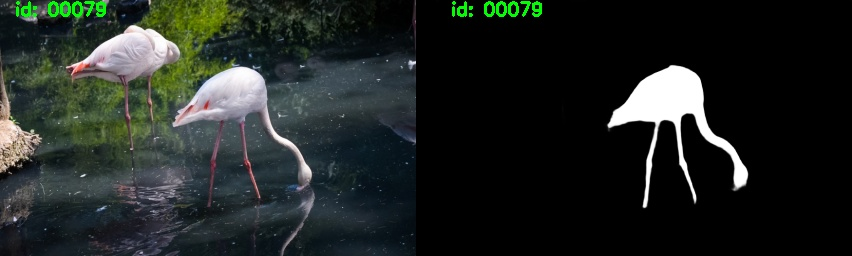

end


In [6]:
src_dir = './video_object_segmention/OSVOS-PyTorch/DAVIS_2016/JPEGImages/480p/flamingo'
result_dir = './video_object_segmention/OSVOS-PyTorch/./models/Results/flamingo'
files = os.listdir(result_dir)
files.sort()
for file_name in files:
    clear_output(wait=True)
    src_img = cv2.imread(os.path.join(src_dir, file_name.split('.')[0] + '.jpg'))
    result_img = cv2.imread(os.path.join(result_dir, file_name))
    src_img = cv2.resize(src_img, (416, 256), interpolation=cv2.INTER_AREA)
    result_img = cv2.resize(result_img, (416, 256), interpolation=cv2.INTER_AREA)
    cv2.putText(src_img, 'id: ' + str(file_name.split('.')[0]), (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)  # 画frame_id
    cv2.putText(result_img, 'id: ' + str(file_name.split('.')[0]), (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)  # 画frame_id
    img_show = np.hstack((src_img, np.zeros((256, 20, 3), dtype=src_img.dtype), result_img))
    display(Image(data=cv2.imencode('.jpg', img_show)[1]))
    time.sleep(0.04)
print('end')

可以从上面的分割结果看出，目标大概是能被分割的，但是细节部分还存在一些差异，特别是目标之外的区域也被分割了

## 3. 视频物体分割的应用
如果你已经得到了一个视频的物体分割结果，那么可以用来做什么呢？

视频物体分割是一项广泛使用的技术，电影电视特效、短视频直播等可以用该技术将场景中的前景从背景中分离出来，通过修改或替换背景，可以将任务设置在现实不存在或不易实现的场景、强化信息的冲击力。传统方式可通过视频图像的手工逐帧抠图方式（比如，摄影在带绿幕的专业摄影棚环境摄制，后期特效完成背景移除切换，如下图所示），比如《复仇者联盟》《美国队长》《钢铁侠》等通过专业影视处理软件加入各种逼真的特效，让影片更加有趣，更加震撼。

![koutu.jpg](./imgs/koutu.jpg)

再比如华为Mate 20系列手机新增的人像留色功能，能够在录像过程中，实时识别出人物的轮廓，然后通过AI优化只保留人物衣服、皮肤、头发的颜色，将周边景物全部黑白化，如此一来使人物主体更加突出，打造大片既视感。这种人像留色功能就是使用了视频物体分割的技术，将人物从视频中分割出来，再保留其色彩。

![renxiangliuse.jpg](./imgs/renxiangliuse.jpg)
![renxiangliuse_2.jpg](./imgs/renxiangliuse_2.jpg)

接下来，我们将实现视频抠图的另一种应用：将某个目标从视频中去掉，仿佛该目标从来没在视频中出现过一样。本案例采用的视频抠图算法是[Deep Flow-Guided Video Inpainting](https://arxiv.org/pdf/1905.02884.pdf)

### 3.1 准备代码和数据
相关代码、数据和模型都已准备好存放在OBS中，执行下面一段代码即可将其拷贝到Notebook中。

In [7]:
import os
import subprocess
import moxing as mox

print('Downloading datasets and code ...')
if not os.path.exists('./video_object_segmention/Deep-Flow-Guided-Video-Inpainting'):
    mox.file.copy('s3://modelarts-labs-bj4/notebook/DL_video_object_segmentation/Deep-Flow-Guided-Video-Inpainting.zip', 
                  './video_object_segmention/Deep-Flow-Guided-Video-Inpainting.zip')
    p1 = subprocess.run(['cd ./video_object_segmention/;unzip Deep-Flow-Guided-Video-Inpainting.zip;rm Deep-Flow-Guided-Video-Inpainting.zip'], 
                        stdout=subprocess.PIPE, shell=True, check=True)
    if os.path.exists('./video_object_segmention/Deep-Flow-Guided-Video-Inpainting'):
        print('Download success')
    else:
        raise Exception('Download failed')
else:
    print('Download success')

INFO:root:Using MoXing-v1.15.1-92d9ed92
INFO:root:Using OBS-Python-SDK-3.1.2


Download success


### 3.2 运行算法demo
回到 ModelArts Notebook 页面，按照下图打开一个terminal：
![open_terminal.jpg](./imgs/open_terminal.jpg)
然后复制以下四条命令到terminal中粘贴执行，执行过程耗时约2分半：
```shell

source activate /home/ma-user/anaconda3/envs/Pytorch-1.0.0

cd `find ~/work/ -name "Deep-Flow-Guided-Video-Inpainting"`

bash install_scripts.sh

python tools/video_inpaint.py --frame_dir ../OSVOS-PyTorch/DAVIS_2016/JPEGImages/480p/flamingo --MASK_ROOT ../OSVOS-PyTorch/DAVIS_2016/Annotations/480p/flamingo --img_size 512 832 --FlowNet2 --DFC --ResNet101 --Propagation --enlarge_mask
```

### 3.3 查看视频抠图结果
执行下面这段代码将看到视频抠图的结果，左侧视频是原视频，右侧视频是去除了一只火烈鸟目标之后的视频，可以看到目标抠除的效果是非常好的，完全不影响背景，仿佛这个目标在视频中就从来没有出现过一样。

注意：由于视频物体分割算法的发展时间较短，离实用场景还有一段距离，所以本案例的视频抠图demo使用的目标分割区域是人工标注的（存储位置在./video_object_segmention/Deep-Flow-Guided-Video-Inpainting/demo/masks），而不是上面的OSVOS算法输出的分割区域。

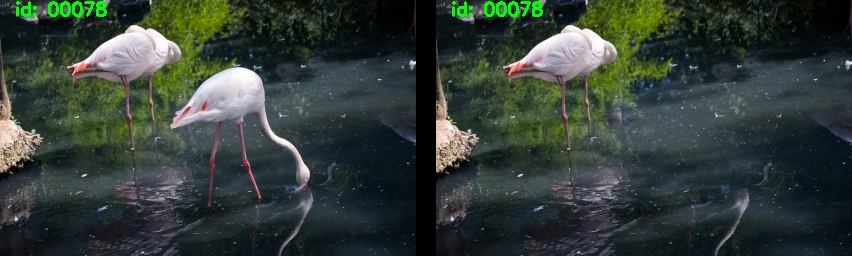

end


In [8]:
src_dir = './video_object_segmention/OSVOS-PyTorch/DAVIS_2016/JPEGImages/480p/flamingo'
result_dir = './video_object_segmention/OSVOS-PyTorch/DAVIS_2016/JPEGImages/480p/Inpaint_Res/inpaint_res'
files = os.listdir(result_dir)
files.sort()
for file_name in files:
    clear_output(wait=True)
    src_img = cv2.imread(os.path.join(src_dir, file_name.split('.')[0] + '.jpg'))
    result_img = cv2.imread(os.path.join(result_dir, file_name))
    src_img = cv2.resize(src_img, (416, 256), interpolation=cv2.INTER_AREA)
    result_img = cv2.resize(result_img, (416, 256), interpolation=cv2.INTER_AREA)
    cv2.putText(src_img, 'id: ' + str(file_name.split('.')[0]), (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)  # 画frame_id
    cv2.putText(result_img, 'id: ' + str(file_name.split('.')[0]), (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)  # 画frame_id
    img_show = np.hstack((src_img, np.zeros((256, 20, 3), dtype=src_img.dtype), result_img))
    display(Image(data=cv2.imencode('.jpg', img_show)[1]))
    time.sleep(0.02)
print('end')

参考资料

[视频分割在移动端的算法进展综述](https://zhuanlan.zhihu.com/p/60621619)

[视频物体分割算法的三个方向与最新应用](https://new.qq.com/omn/20190731/20190731A0BMCE00.html)

[https://davischallenge.org/index.html](https://davischallenge.org/index.html)

[https://github.com/kmaninis/OSVOS-PyTorch](https://github.com/kmaninis/OSVOS-PyTorch)

[https://github.com/nbei/Deep-Flow-Guided-Video-Inpainting](https://github.com/nbei/Deep-Flow-Guided-Video-Inpainting)

[A Benchmark Dataset and Evaluation Methodology for Video Object Segmentation](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Perazzi_A_Benchmark_Dataset_CVPR_2016_paper.pdf)